In [14]:
import random
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
import pandas as pd

# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {'text': self.texts[idx]}
        if self.labels is not None:
            item['label'] = self.labels[idx]
        return item

# Tokenization function
def tokenize_function(tokenizer, batch):
    inputs = tokenizer([item['text'] for item in batch], truncation=True, padding=True, max_length=128, return_tensors="pt")
    if 'label' in batch[0]:
        inputs['labels'] = torch.tensor([item['label'] for item in batch])
    return inputs

# Training function
def train_model(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    return accuracy, f1, precision

# Hyperparameter tuning
LEARNING_RATES = [1e-5, 1e-4, 1e-3]
BATCH_SIZES = [8, 32, 64]
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
EPOCHS = 5  # Set initial epochs; you can adjust based on performance
PATIENCE = 2  # Early stopping patience

# Load data
DATA_PATH = "C:\\Users\\Shamailh_M77\\Downloads\\AmazonDataset\\Reviews.csv"
df = pd.read_csv(DATA_PATH).head(5000)  # Limit data for faster analysis
texts = df['Text'].tolist()
labels = df['Score'].map({
    1: 0,  # Negative
    2: 0,  # Negative
    3: 1,  # Neutral
    4: 2,  # Positive
    5: 2   # Positive
}).tolist()

# Split data: 60% train, 20% validation, 20% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.4, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

# Dataset and DataLoader
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)
test_dataset = SentimentDataset(test_texts, test_labels)

# Results storage
best_config = None
best_performance = 0
patience_counter = 0
best_val_loss = float('inf')

# Hyperparameter tuning with early stopping
for lr in LEARNING_RATES:
    for batch_size in BATCH_SIZES:
        print(f"\nTraining with learning rate: {lr} and batch size: {batch_size}")
        
        # Prepare dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tokenize_function(tokenizer, x))
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tokenize_function(tokenizer, x))
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tokenize_function(tokenizer, x))
        
        # Optimizer
        optimizer = AdamW(model.parameters(), lr=lr)
        
        # Early stopping and training loop
        for epoch in range(EPOCHS):
            print(f"Epoch {epoch + 1}/{EPOCHS}")
            
            # Train the model
            train_loss = train_model(model, train_dataloader, optimizer, device)
            print(f"Training loss: {train_loss:.4f}")
            
            # Evaluate the model on validation set
            val_accuracy, val_f1, val_precision = evaluate_model(model, val_dataloader, device)
            print(f"Validation Metrics:\nAccuracy: {val_accuracy:.4f}\nF1 Score: {val_f1:.4f}\nPrecision: {val_precision:.4f}")
            
            # Early stopping check
            if val_accuracy > best_performance:
                best_performance = val_accuracy
                best_config = {'learning_rate': lr, 'batch_size': batch_size}
                patience_counter = 0  # Reset patience if improvement is seen
            else:
                patience_counter += 1
                
            if patience_counter >= PATIENCE:
                print("Early stopping triggered. No improvement in validation accuracy.")
                break
        
        # Final evaluation on the test set after training
        test_accuracy, test_f1, test_precision = evaluate_model(model, test_dataloader, device)
        print(f"\nTest Metrics (final evaluation):\nAccuracy: {test_accuracy:.4f}\nF1 Score: {test_f1:.4f}\nPrecision: {test_precision:.4f}")

print(f"\nBest Configuration based on Validation Accuracy: {best_config} with Validation Accuracy: {best_performance:.4f}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

D:\Anaconda\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map_location)


Training with learning rate: 1e-05 and batch size: 8
Epoch 1/5


D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training loss: 0.3866


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.8800
F1 Score: 0.8466
Precision: 0.8176
Epoch 2/5
Training loss: 0.2770
Validation Metrics:
Accuracy: 0.8860
F1 Score: 0.8808
Precision: 0.8792
Epoch 3/5
Training loss: 0.1874
Validation Metrics:
Accuracy: 0.8930
F1 Score: 0.8859
Precision: 0.8816
Epoch 4/5
Training loss: 0.1236
Validation Metrics:
Accuracy: 0.8860
F1 Score: 0.8800
Precision: 0.8759
Epoch 5/5
Training loss: 0.0763
Validation Metrics:
Accuracy: 0.8950
F1 Score: 0.8811
Precision: 0.8811

Test Metrics (final evaluation):
Accuracy: 0.8800
F1 Score: 0.8695
Precision: 0.8640

Training with learning rate: 1e-05 and batch size: 32
Epoch 1/5


D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training loss: 0.0378
Validation Metrics:
Accuracy: 0.8860
F1 Score: 0.8829
Precision: 0.8807
Epoch 2/5
Training loss: 0.0133
Validation Metrics:
Accuracy: 0.8850
F1 Score: 0.8828
Precision: 0.8808
Early stopping triggered. No improvement in validation accuracy.

Test Metrics (final evaluation):
Accuracy: 0.8720
F1 Score: 0.8700
Precision: 0.8683

Training with learning rate: 1e-05 and batch size: 64
Epoch 1/5


D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training loss: 0.0133
Validation Metrics:
Accuracy: 0.8790
F1 Score: 0.8797
Precision: 0.8808
Early stopping triggered. No improvement in validation accuracy.

Test Metrics (final evaluation):
Accuracy: 0.8730
F1 Score: 0.8751
Precision: 0.8782

Training with learning rate: 0.0001 and batch size: 8
Epoch 1/5


D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training loss: 0.7205


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.7770
F1 Score: 0.6795
Precision: 0.6037
Early stopping triggered. No improvement in validation accuracy.


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Test Metrics (final evaluation):
Accuracy: 0.7640
F1 Score: 0.6618
Precision: 0.5837

Training with learning rate: 0.0001 and batch size: 32
Epoch 1/5
Training loss: 0.7002


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.7770
F1 Score: 0.6795
Precision: 0.6037
Early stopping triggered. No improvement in validation accuracy.


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Test Metrics (final evaluation):
Accuracy: 0.7640
F1 Score: 0.6618
Precision: 0.5837

Training with learning rate: 0.0001 and batch size: 64
Epoch 1/5
Training loss: 0.7040


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.7770
F1 Score: 0.6795
Precision: 0.6037
Early stopping triggered. No improvement in validation accuracy.


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Test Metrics (final evaluation):
Accuracy: 0.7640
F1 Score: 0.6618
Precision: 0.5837

Training with learning rate: 0.001 and batch size: 8
Epoch 1/5
Training loss: 0.7396


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.7770
F1 Score: 0.6795
Precision: 0.6037
Early stopping triggered. No improvement in validation accuracy.


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Test Metrics (final evaluation):
Accuracy: 0.7640
F1 Score: 0.6618
Precision: 0.5837

Training with learning rate: 0.001 and batch size: 32
Epoch 1/5
Training loss: 0.7023


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.7770
F1 Score: 0.6795
Precision: 0.6037
Early stopping triggered. No improvement in validation accuracy.


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Test Metrics (final evaluation):
Accuracy: 0.7640
F1 Score: 0.6618
Precision: 0.5837

Training with learning rate: 0.001 and batch size: 64
Epoch 1/5
Training loss: 0.6971


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.7770
F1 Score: 0.6795
Precision: 0.6037
Early stopping triggered. No improvement in validation accuracy.


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Metrics (final evaluation):
Accuracy: 0.7640
F1 Score: 0.6618
Precision: 0.5837

Best Configuration based on Validation Accuracy: {'learning_rate': 1e-05, 'batch_size': 8} with Validation Accuracy: 0.8950


('fine_tuned_roberta\\tokenizer_config.json',
 'fine_tuned_roberta\\special_tokens_map.json',
 'fine_tuned_roberta\\vocab.json',
 'fine_tuned_roberta\\merges.txt',
 'fine_tuned_roberta\\added_tokens.json',
 'fine_tuned_roberta\\tokenizer.json')

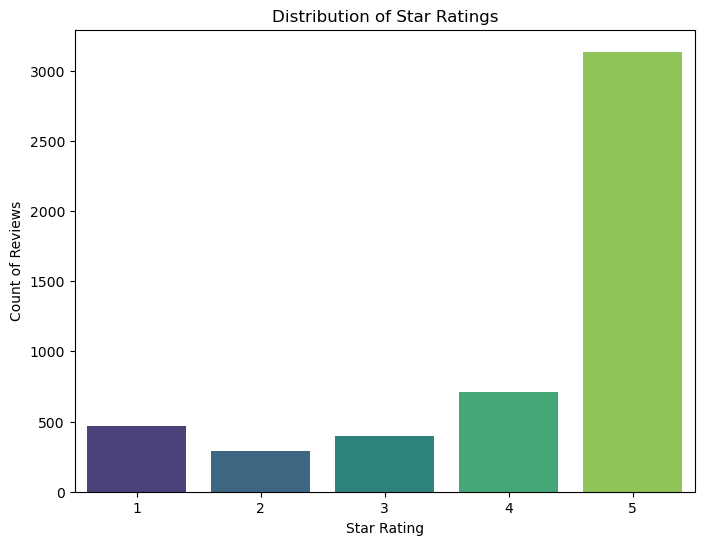

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of star ratings
rating_counts = df['Score'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count of Reviews")
plt.show()


In [18]:
# import matplotlib.pyplot as plt

# # get inside train loop
# train_losses = []
# for epoch in range(10):  
#     train_loss = train_model(model, train_dataloader, optimizer, device)
#     train_losses.append(train_loss)

# # Ploting the loss chart
# plt.plot(range(1, len(train_losses) + 1), train_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss Curve')
# plt.show()


Label Distribution: Counter({5: 1268, 4: 307, 1: 172, 3: 146, 2: 107})


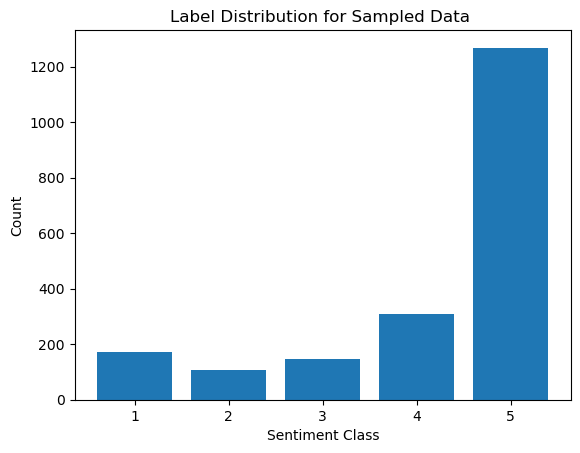

In [26]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file
df = pd.read_csv(DATA_PATH)  # Replace with your actual dataset file

# Sample 5000 rows from the dataset
df_sampled = df.sample(n=2000, random_state=42)  # Set random_state for reproducibility

# Extract labels (replace 'Score' with the actual column name for sentiment)
labels = df_sampled['Score']

# Count occurrences of each label
label_counts = Counter(labels)
print("Label Distribution:", label_counts)

# Visualize the label distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Label Distribution for Sampled Data ")
plt.show()

